In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

import colorednoise as cn

from hr.esm import EsmModel, BlockEsmModel
from hr.preprocess import NoiseWhitening, FiltreBank
from hr.process import Esprit, Ester, AdaptiveEsprit, BlockEsprit
from hr.util import _PINK_FILTRE_COEFFS
from util.util import to_db, snr

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple noiseless 'harmonic' signal

In [23]:
sr = 44100
n_s = 100000
n_fft = 1024

# number of sinusoids
r = 8 
# Normalised damping ratios, multiply by sampling rate to get the 'deltas' in Amp.s-1
gammas = rng.uniform(0.001, 0.01, r) 
# Normalised frequencies
nus = rng.normal(0.1, 0.05, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_esm = EsmModel(gammas, nus, amps, phis)

x_sine = x_esm.synth(n_s)

n_est = 20
x_esm_est = Esprit.estimate_esm(x_sine, n_est, r)

print(x_esm.nus * sr)
print(x_esm_est.nus * sr)
print(x_esm.gammas * sr)
print(x_esm_est.gammas * sr)

[1045.32345363 2930.24726624 3699.13199887 3711.90703018 4624.25393767
 4710.5880781  6615.59407035 7038.72625954]
[1045.32345363 2930.2472183  3699.14965726 3711.91221792 4624.25405228
 4710.58819754 6615.59406906 7038.7262598 ]
[117.27717167 366.42030969  65.46156236 314.92545452 131.5608335
 153.87237849 410.57562972 113.91705214]
[117.27717194 366.42033984  65.44860089 314.8502104  131.56070788
 153.87223237 410.57563691 113.91705033]


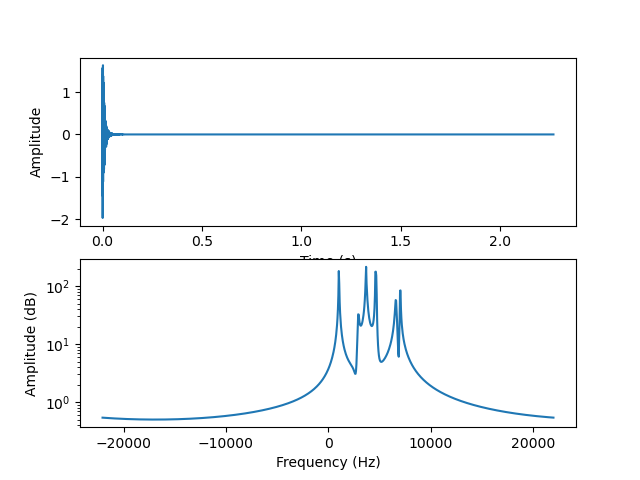

In [24]:
ts_plot = np.arange(n_s) / sr # times in seconds
fs_plot = np.fft.fftfreq(n_fft) * sr

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_plot), np.fft.fftshift(np.abs(x_sine_ft)))
plt.show()

In [25]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

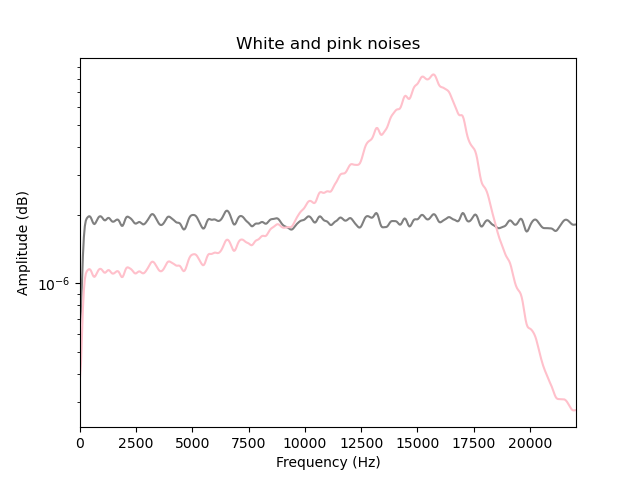

In [26]:
white_noise = rng.random(n_s)
pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft, return_onesided=False)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("White and pink noises")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(white_noise_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(pink_noise_psd), c='pink')
plt.xlim(np.array([0, 0.5])*sr)
plt.show()

### Whitening the noise

In [27]:
noise_ratio = 0.001
noise = noise_ratio*pink_noise

x = x_sine + noise
print(np.mean(np.real(x_sine)), np.mean(noise))
x_snr =snr(np.real(x_sine), noise)
print(f'SNR={x_snr} dB')

3.791134227402423e-05 0.00038188768942203397
SNR=37.79281353987773 dB


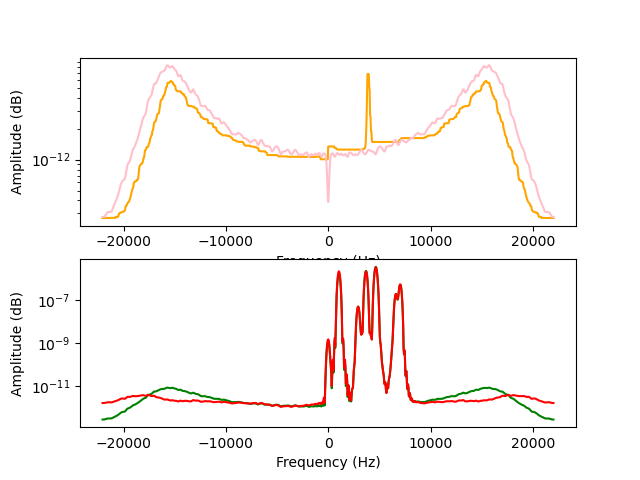

In [28]:
smoothing_factor = 8
quantile_ratio = 0.05
ar_ordre = 10

# fs_x_psd, x_psd = sig.welch(x, fs=1, nfft=n_fft)
fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft, return_onesided=False)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft, return_onesided=False)

noise_psd_est = NoiseWhitening.estimate_noise_psd(x, fs=sr, n_fft=n_fft, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
noise_filtre_coeffs_est = NoiseWhitening.estimate_noise_ar_coeffs(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white = NoiseWhitening.whiten(x, fs=sr, n_fft=n_fft, ar_ordre=ar_ordre, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft, return_onesided=False)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("PSD estimation of the noise and whitened signal")
plt.subplot(2, 1, 1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(noise_psd_est), c='orange')
plt.semilogy(np.fft.fftshift(fs_noise_psd), np.fft.fftshift(noise_psd), c='pink')
# plt.xlim(np.array([0, 0.5]) * sr)
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
# plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_psd), c='green')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='r')
plt.show()

In [29]:
ipd.Audio(np.real(x), rate=sr)


### ESM model ordre estimation

#### Does seem to work correctly with the whitened signal!

The whitening process seems to hurt the estimation
of the ESM model ordre with ESTER.
We should use ESTER with the signal whose noise
has not been whitened.

#### Choice of $p_{max}$

According to the article, $p_{max}$ should be 
much lower than $n$.
So according to our expectation on $r$, we should choose
$n$ large enough.

Still unclear, but if $p_{max} > r$
the _a posteriori error bound_ from $E$ 
gives some indication somehow?

In the article:

For each eigenvalue ̂$\hat{z}$ of $\Phi(p)$, 
there is an eigenvalue $z_k$ of $\Phi(r)$ for which:

$$
|\hat{z} − z_k| \leq \kappa_2 ||E(p)||_2
$$ 


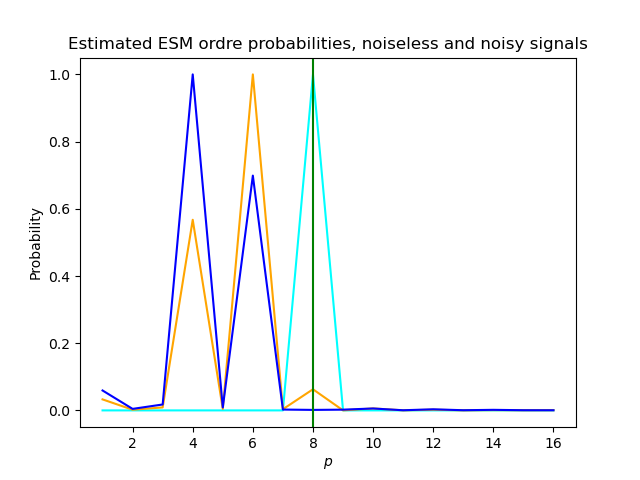

Ordre of the ESM model
Truth=8
Estimated: Noiseless=8, Noisy=6, Whitened=6


In [30]:
n_est = 32
p_max = 16 # for now
ps = np.arange(1,p_max+1)
j_sine = Ester.inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = Ester.inverse_error_func(x, n=n_est, p_max=p_max)
j_white = Ester.inverse_error_func(x_white, n=n_est, p_max=p_max)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.axvline(r, ymin=0, ymax=1, c='g')
plt.show()

r_est_sine = Ester.estimate_esm_ordre(x_sine, n_est, p_max)
r_est_noise = Ester.estimate_esm_ordre(x, n_est, p_max)
r_est_white = Ester.estimate_esm_ordre(x_white, n_est, p_max)
print('Ordre of the ESM model')
print(f'Truth={r}')
print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')

### Test of the model with whitened signal


We use the ESM model ordre estimated on the 
whitened signal, and apply ESPRIT on
the whitened signal.

[1045.32345363 2930.24726624 3699.13199887 3711.90703018 4624.25393767
 4710.5880781  6615.59407035 7038.72625954]
[1045.32186639 3005.65940952 3709.80436901 4649.68533396 6567.10826913
 7032.016317  ]


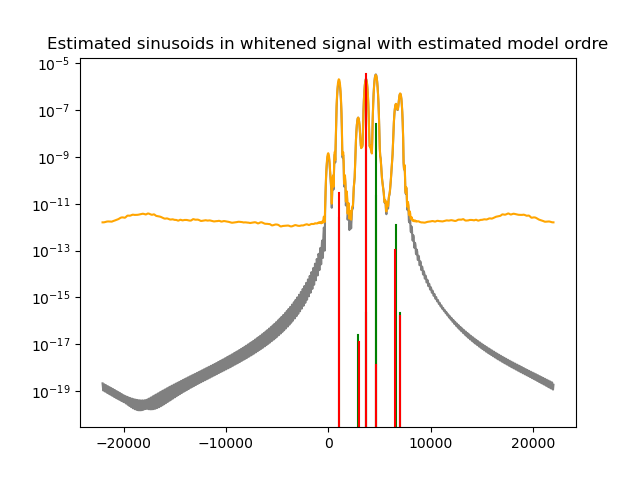

In [31]:
x_esm_est = Esprit.estimate_esm(x_white, n_est, r_est_white)


print(x_esm.nus * sr)
print(x_esm_est.nus * sr)

plt.figure()
plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
# plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
    pass
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')
plt.show()


In [32]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)

### Filter bank


#### Problem

__What transformation to apply to the estimated frequency in the band $\nu_{i,\text{band}}^k$ to apply to find the estimated frequency $\nu_i^k$?__

$$
\nu_i^k = \frac{\nu_{i,\text{band}}^k}{s} + \nu_c^k
$$

With $\nu_c^k = \frac{k}{N_{ft}}$ the centre frequency for band $k$, and $s$ the step in the STFT.

[0.023668087189130542, 0.0838349436538412, 0.1050178024144084, 0.14866808718913055, 0.2088349436538412, 0.2300178024144084, 0.27366808718913055, 0.3338349436538412, 0.3550178024144084, 0.39866808718913055, 0.4588349436538412, 0.4800178024144084]
[0.08417023 0.08388054 0.10485837 0.02370348 0.15960831 0.06644552
 0.15001347 0.10681606]


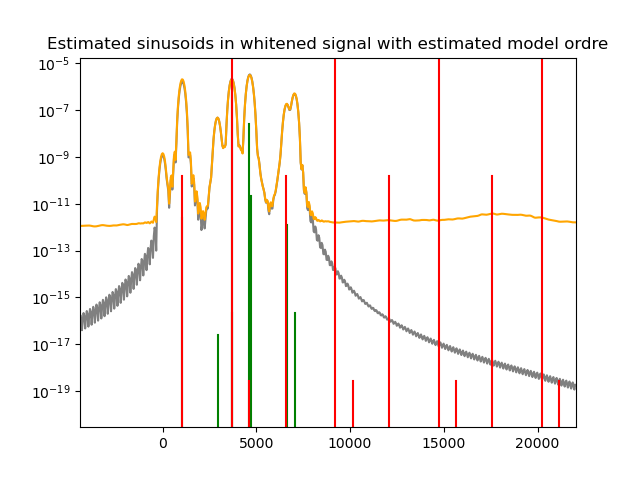

In [49]:
# number of bands
nb_bands = 4
ordre_filtre = 21
w_trans_hz = 20
bank = FiltreBank(nb_bands, ordre_filtre=ordre_filtre, w_trans=w_trans_hz/sr)
x_bands = bank.process(x_white)
nus_centre = np.arange(nb_bands)/(2*nb_bands)

rs_est = []
gammas_est = []
nus_est = []
amps_est = []
phis_est = []

n_est_fb = 32
p_max_fb = 8
for k in range(nb_bands):
    x_band = x_bands[k]
    r_band = Ester.estimate_esm_ordre(x_band, n=n_est_fb, p_max=p_max_fb)
    rs_est.append(r_band)
    w_cap, _ = Esprit.subspace_weighting_mats(x_band, n_est, rs_est[k])
    phi_cap = Esprit.spectral_matrix(w_cap)
    zs, _ = Esprit.estimate_poles(phi_cap)
    
    alphas = Esprit.estimate_esm_alphas(x_band, zs)
    gammas_est_band, nus_est_band = EsmModel.poles_to_dampfreq(zs)
    amps_est_band, phis_est_band = EsmModel.alphas_to_ampphase(alphas)
    # TODO: Not right, fix this
    nus_est_band = nus_est_band/nb_bands + nus_centre[k]
    nus_est += nus_est_band.tolist()
    gammas_est += gammas_est_band.tolist()
    amps_est += amps_est_band.tolist()
    phis_est += phis_est_band.tolist()

print(nus_est)
print(nus)
nus_est = np.array(nus_est)
# print(np.amin(nus_est), np.amax(nus_est))
x_esm_est = EsmModel(gammas_est, nus_est, amps_est, phis_est)
#print(x_esm_est.nus * sr)
#print(x_esm_est.nus * sr)
plt.clf()
plt.figure()
plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')
plt.show()

In [40]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)

### Adaptive ESPRIT

#### Using a custom adaptive ESM

In [6]:
sr = 4410
n_s = 8000
n_fft = 1024

log_progress = False

nb_blocks = 10
l_block = n_s // nb_blocks
# number of sinusoids
r = 8
# Normalised damping ratios, multiply by sampling rate to get the 'deltas' in Amp.s-1
gammas_list = np.repeat(rng.normal(0.002, 0.0001, (nb_blocks, r)), l_block, axis=0)
# Normalised frequencies
nus_list = np.repeat(rng.normal(0.1, 0.05, (nb_blocks, r)), l_block, axis=0)
amps_list = np.repeat(rng.uniform(0.1, 1, (nb_blocks, r)), l_block, axis=0)
phis_list = np.repeat(rng.uniform(0, 2 * np.pi, (nb_blocks, r)), l_block, axis=0)

x_esm = BlockEsmModel.from_param_lists(
    gammas_list, nus_list, amps_list, phis_list
)

# one sample per value
x_sine = x_esm.synth(1)

n_est = 32
l = 120
x_esm_est = BlockEsprit.estimate_esm(
    x_sine, n_est, r, l, step=50
)

print(x_esm.nus[0] * sr)
print(x_esm_est.nus[0] * sr)
# print(x_esm.gammas * sr)
# print(x_esm_est.gammas * sr)

# x_sine_est = x_esm_est.synth(n_s_block)


[152.90130409 152.90130409 152.90130409 ... 251.49543544 251.49543544
 251.49543544]
[-386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.13653734
 -386.13653734 -386.13653734 -386.13653734 -386.13653734 -386.1